In [1]:
#pip install opencv-python

In [1]:
import numpy as np 
import cv2
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt       
%matplotlib inline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
#cleaningBackground

# load image
image = cv2.imread('healthy_test.jpg')
# create hsv
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 # set lower and upper color limits
low_val = (0,60,0)
high_val = (179,255,255)
# Threshold the HSV image 
mask = cv2.inRange(hsv, low_val,high_val)
# remove noise
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((8,8),dtype=np.uint8))
# apply mask to original image
result = cv2.bitwise_and(image, image,mask=mask)

#show image
# cv2.imshow("Result", result)
# cv2.imshow("Mask", mask)
# cv2.imshow("Image", image)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
#[cv2.imread(file) for file in glob.glob('TomatoDataset\\Tomato_healthy\\*.JPG')]

low_val = (0,60,0)
high_val = (179,255,255)

# Getting healthy leaf images (10)
healthy = [cv2.imread(file) for file in glob.glob('TomatoDataset\\Tomato_healthy\\*.JPG')]

#cleaning the images
healthy_cleaned = []
for healt in healthy:
    hsv = cv2.cvtColor(healt, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, low_val,high_val)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((8,8),dtype=np.uint8))
    healthy_cleaned.append(cv2.bitwise_and(healt, healt,mask=mask))
    


# Getting health leaf images (10)
diseased  = [cv2.imread(file) for file in glob.glob('TomatoDataset\\Tomato_leaf_curl\\*.JPG')]
diesased_cleaned = []

for dies in diseased:
    hsv = cv2.cvtColor(dies, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, low_val,high_val)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((8,8),dtype=np.uint8))
    diesased_cleaned.append(cv2.bitwise_and(dies, dies,mask=mask))

In [ ]:
# Use this to check images
cv2.imshow("Image", diesased_cleaned[8])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
# Feature gathering
red_mean = []
blue_mean = []
green_mean = []
contrast = [] # not used yet. Need to download a package to get this feature
label = [] # Healthy leafs = 1, diseased = 2

for healt in healthy:
    label.append(1)
    red_mean.append(np.mean(healt[:,:,0]))
    blue_mean.append(np.mean(healt[:,:,1]))
    green_mean.append(np.mean(healt[:,:,2]))
    
    # Converting image to grayscale
#     gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
#     textures = mt.features.haralick(gs)
#     ht_mean = textures.mean(axis=0)
    

for dies in diseased:
    label.append(2)
    red_mean.append(np.mean(dies[:,:,0]))
    blue_mean.append(np.mean(dies[:,:,1]))
    green_mean.append(np.mean(dies[:,:,2]))
    
    
leaves = {"label":label, "RedMean":red_mean, "BlueMean":blue_mean, "GreenMean": green_mean}
leaves_df = pd.DataFrame(leaves)

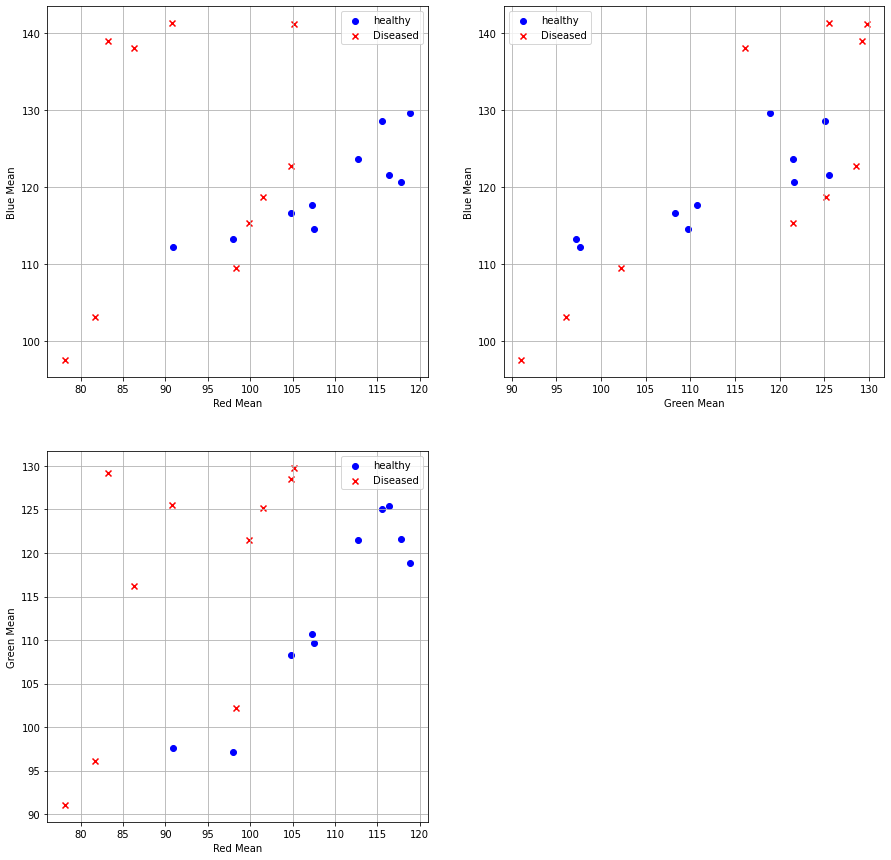

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.scatter(leaves_df["RedMean"][:10],leaves_df["BlueMean"][:10], label = "healthy", marker = 'o', color = 'blue')
plt.scatter(leaves_df["RedMean"][10:],leaves_df["BlueMean"][10:], label = "Diseased", marker = 'x', color ='red')
plt.title('')
plt.xlabel("Red Mean")
plt.ylabel("Blue Mean")
plt.grid()
plt.legend()

plt.subplot(2,2,2)
plt.scatter(leaves_df["GreenMean"][:10],leaves_df["BlueMean"][:10], label = "healthy", marker = 'o', color = 'blue')
plt.scatter(leaves_df["GreenMean"][10:],leaves_df["BlueMean"][10:], label = "Diseased", marker = 'x', color ='red')
plt.title('')
plt.xlabel("Green Mean")
plt.ylabel("Blue Mean")
plt.grid()
plt.legend()

plt.subplot(2,2,3)
plt.scatter(leaves_df["RedMean"][:10],leaves_df["GreenMean"][:10], label = "healthy", marker = 'o', color = 'blue')
plt.scatter(leaves_df["RedMean"][10:],leaves_df["GreenMean"][10:], label = "Diseased", marker = 'x', color ='red')
plt.title('')
plt.xlabel("Red Mean")
plt.ylabel("Green Mean")
plt.grid()
plt.legend()


In [5]:
# Making SVM model
X = leaves_df.drop(columns= ["label", "BlueMean"], axis = 1)
y = leaves_df["label"]
clf = SVC(kernel='linear', C = 1) # Linear Kernel
clf.fit(X, y)

In [7]:
clf.coef_

array([[-0.1561162 ,  0.11171526]])

In [8]:
def plotLine(b0,b1,b2,xmin = 80, xmax = 120):
    """
    Pass in your coefficients to draw the line 
    b0 + b1 * X_1 + b2 * X_2 = 0
    """
    a = -b1 / b2
    xx = np.linspace(xmin,xmax)
    yy = a * xx - b0 / b2

    plt.plot(xx,yy, color = "blue")
    

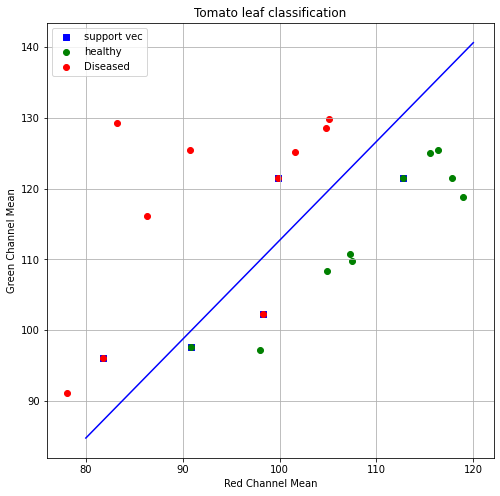

In [46]:
sv = clf.support_vectors_

plt.figure(figsize=(8,8))
plt.scatter(sv[:,0], sv[:,1], label = 'support vec', marker = 's', color ='blue')
plt.scatter(leaves_df["RedMean"][:10],leaves_df["GreenMean"][:10], label = "healthy", marker = 'o', color = 'green')
plt.scatter(leaves_df["RedMean"][10:],leaves_df["GreenMean"][10:], label = "Diseased", marker = 'o', color ='red')
plotLine(clf.intercept_, clf.coef_[0][0], clf.coef_[0][1])

plt.title('Tomato leaf classification')
plt.xlabel("Red Channel Mean")
plt.ylabel("Green Channel Mean")
plt.grid()
plt.legend()
plt.savefig('Tomato_SVC_RGChannel.png')
plt.show()